In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import helpers  # Notebook helpers

sys.path.append(os.path.join('..'))
from adp.curve import * 
from adp.utility import *
from adp.plot import *
from adp.funcs import *
from adp.optim import *

In [2]:
# Fetch/download data
D = helpers.fetch_german_data()
X, y, dtypes, feature_labels = D['X'], D['y'], D['dtypes'], D['feature_labels']

# Split the data based on some feature value
base_idx = np.where(X[:, 4] > 1000)[0]
X_base = X[base_idx]
y_base = y[base_idx]

unseen_idx = np.where(X[:, 4] <= 1000)[0]
X_unseen = X[unseen_idx]
y_unseen = y[unseen_idx]
print('Seen data:%d'%X_base.shape[0])
print('Unseen data:%d'%(X_unseen.shape[0]))

X_base, y_base = shuffle(X_base, y_base, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.1, random_state=0)
print('# train', len(y_train))
print('# test', len(y_test))

Seen data:884
Unseen data:116
# train 795
# test 89


In [3]:
# Train models
#model_names = ['RBFSVM', 'RandomForest', 'DNN', 'DecisionTree', 'GradientBoost']
model_names = ['DNN']
model_dicts = helpers.create_and_train_models(model_names, dtypes, X_train, y_train, X_test=X_test, y_test=y_test)
model = model_dicts[0]['model']

Loading fitted model from cache via file cached_model_29e958a9a8097784f1d20d6d248c2e6204c64914.pkl


In [4]:
from sklearn.metrics import accuracy_score
unseen_score = accuracy_score(y_unseen, model_dicts[0]['estimator'].predict(X_unseen))
model_dicts[0]['unseen_score'] = unseen_score
print('Train score', model_dicts[0]['train_score'])
print('Test score', model_dicts[0]['test_score'])
print('Unseen score', model_dicts[0]['unseen_score'])

Train score 1.0
Test score 0.8202247191011236
Unseen score 0.7758620689655172


In [5]:
def plot_curve(curve, utility, title_prefix=None):
    # Plot best curve
    model_scores = utility.model(X)
    y_bounds = [np.min(model_scores), np.max(model_scores)]
    n_rows, n_cols = 1, 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=np.array([n_cols*6, n_rows*3])*0.8, dpi=100)
    plot_curve_vals(curve=curve, utility=utility, feature_labels=feature_labels, y_bounds=y_bounds,
                    auxiliary_scoring=None, tick_rotation=15, ax=ax)
    ax.set_ylabel('Score')
    if title_prefix is not None:
        ax.set_title('%s\n%s' % (title_prefix, ax.get_title()))

def plot_best_explanation(X, utility, max_X_samples=100, n_grid=50, random_state=0, **plot_kwargs):
    # Setup model and utility
    
    # Get samples
    n_X_samples = min(max_X_samples, X.shape[0])
    rng = check_random_state(random_state)
    rand_idx = rng.permutation(X.shape[0])
    X_sample = X[rand_idx[:n_X_samples]]

    # Fit for every sample
    best_curves = np.array([
        optimize_curve(x0=xx, utility=utility, X=X, dtypes=dtypes, max_numeric_change=1)
        for xx in X_sample
    ])
    best_utilities = np.array([utility(best_curve, n_grid=n_grid) for best_curve in best_curves])

    # Choose best sample
    best_idx = np.argmax(best_utilities)
    best_curve = best_curves[best_idx]
    
    # Plot
    plot_curve(best_curve, utility, **plot_kwargs)
    return best_curve, rand_idx[best_idx], utility

In [6]:
X_base

array([[ 1., 15.,  3., ...,  1.,  1.,  0.],
       [ 1., 24.,  0., ...,  1.,  0.,  0.],
       [ 3., 24.,  3., ...,  1.,  0.,  0.],
       ...,
       [ 3., 30.,  1., ...,  1.,  1.,  0.],
       [ 3., 60.,  2., ...,  1.,  0.,  0.],
       [ 3., 36.,  1., ...,  1.,  0.,  0.]])

Automatic pdb calling has been turned ON


checkin_acc                         no checking
duration                                     12
credit_history       existing credits paid back
purpose                        radio/television
amount                                     3077
saving_acc                             < 100 DM
present_emp_since                     1-4 years
inst_rate                                     2
personal_status                   male & single
other_debtors                              none
residing_since                                4
property                           car or other
age                                          52
inst_plans                                 none
housing                                     own
num_credits                                   1
job                            skilled employee
dependents                                    1
telephone                         has telephone
foreign_worker                        foreigner
status                                  

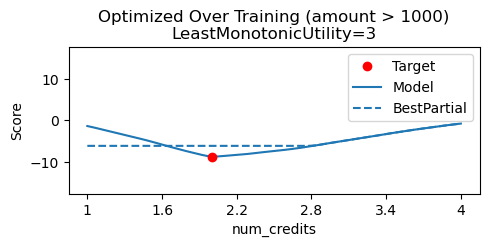

In [7]:
%pdb on 
curve, idx, utility = plot_best_explanation(X_base, LeastMonotonicUtility(model), max_X_samples=1000, 
                                            title_prefix='Optimized Over Training (amount > 1000)')
D['dataframe'].iloc[base_idx[idx]]

checkin_acc                              < 0 DM
duration                                     24
credit_history       existing credits paid back
purpose                               car (new)
amount                                      915
saving_acc                  unknown/no sav acct
present_emp_since                    >= 7 years
inst_rate                                     4
personal_status       female & divorced/married
other_debtors                              none
residing_since                                2
property                           car or other
age                                          29
inst_plans                                 bank
housing                                     own
num_credits                                   1
job                            skilled employee
dependents                                    1
telephone                          no telephone
foreign_worker                        foreigner
status                                  

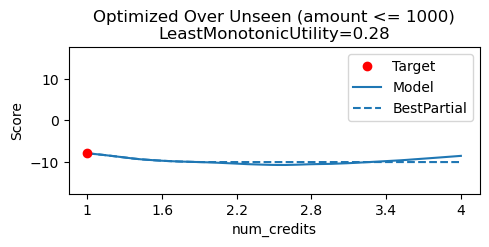

In [8]:
curve, idx, utility = plot_best_explanation(X_unseen, LeastMonotonicUtility(model), max_X_samples=1000,
                                            title_prefix='Optimized Over Unseen (amount <= 1000)')
D['dataframe'].iloc[unseen_idx[idx]]